In [79]:
import numpy as np
from matplotlib import pyplot as plt 
import pandas as pd
import seaborn as sns
from keras.backend import clear_session
from keras.utils import to_categorical
from keras.layers import Dense
from keras.models import Sequential
from keras.metrics import AUC
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve, classification_report
from tensorflow.random import set_seed
from tensorflow import get_logger


get_logger().setLevel('ERROR')

# We use these random seeds to ensure reproductibility
np.random.seed(1)
set_seed(1)

This little project can be found on the Kaggle platform at the following link. The challenge is to classify the health of a fetus as Normal, Suspect or Pathological based on the cardiotocogram exam. The dataset is composed of 1 csv file based on the research work of Ayres-de-Campos et al. [Ayres de Campos et al. (2000) SisPorto 2.0 A Program for Automated Analysis of Cardiotocograms. J Matern Fetal Med 5:311-318]. Let's do some exploratory data analysis.

In [22]:
df = pd.read_csv('data/fetal_health.csv')

df.info()

df.head(n=5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
baseline value                                            2126 non-null float64
accelerations                                             2126 non-null float64
fetal_movement                                            2126 non-null float64
uterine_contractions                                      2126 non-null float64
light_decelerations                                       2126 non-null float64
severe_decelerations                                      2126 non-null float64
prolongued_decelerations                                  2126 non-null float64
abnormal_short_term_variability                           2126 non-null float64
mean_value_of_short_term_variability                      2126 non-null float64
percentage_of_time_with_abnormal_long_term_variability    2126 non-null float64
mean_value_of_long_term_variability                       2126 non-null float64
histogram_wid

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


The dataset is composed of 2126 observations and all the features (there are 21 features and one outcome) are numerical. It appears that no value is missing. Let's see if some data are irrelevant, if there are outliers to tackle with, or if some standardization is needed.

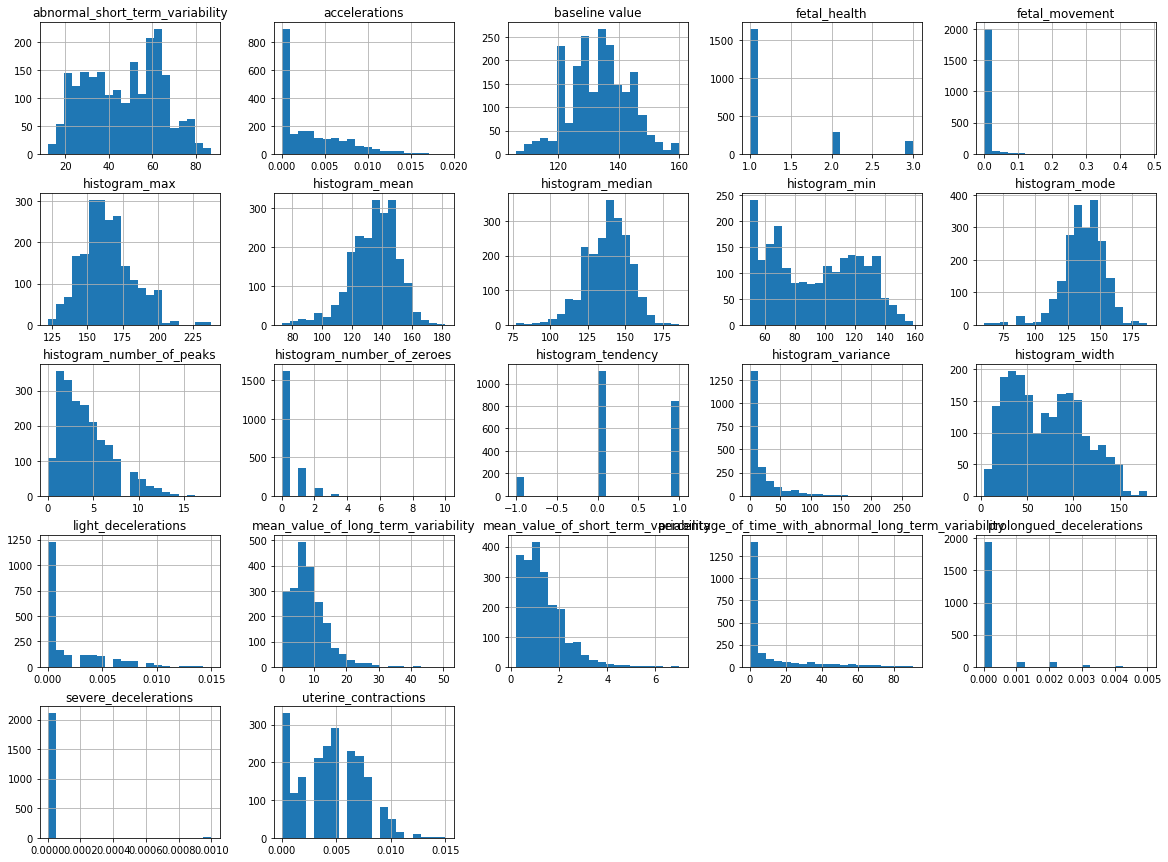

In [23]:
%matplotlib inline
df.hist(bins=20, figsize=(20, 15))
plt.show()

From these histograms, we can notice several points to address to improve a priori the predictive power of a developed machine learning model.
- The variance of the features differs a lot between variables, therefore (it is very common) standardization is needed
- The feature "histogram_tendency" has -1, 0, 1 values but we do not know what they correspond to (are they categories?). Without extra information (there is nothing about it in the documentation), it is probably safer not to consider this feature
A last idea to consider : 
- Regarding the outcome we want to predict : we observe that there are way more healthy foetus rather than suspect or pathological ones. It could be good to stratify the data while splitting to train the model on a dataset with a more balanced distribution of 'healthy', 'suspect' and 'pathological' foetuses

Let's try and compare two approaches :
1) The "brute force approach" : Developing a deep learning model (RNN) without performing any feature engineering.
2) A more "time-costly" approach using feature selection and feature engineering. 

Let's go ! 

In [24]:
#Let's remove the "histogram_tendency", standardize the data and split it between a train and test set
df = df.drop(['histogram_tendency'], axis=1)

X, y = df.drop(['fetal_health'],axis=1), df['fetal_health']

In [25]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

encoder = OneHotEncoder()
y = encoder.fit_transform(y.values.reshape(-1,1)).toarray()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state = 42)

In [45]:
def compile_model():
    clear_session()

    model = Sequential()

    model.add(Dense(20, input_shape=(20,), activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(3, activation='sigmoid'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [46]:
loss, val_loss = [[],[]]

model = compile_model()
our_model = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                      epochs=100, verbose=0)

loss.append(our_model.history['loss'])
val_loss.append(our_model.history['val_loss'])

Let's get a first sense of the optimal number of epochs needed so that our model generalize enough from data without overfitting. Instead of training our model on the all set at once, we will train our model on smaller subsets (it is faster to train on smaller subsets and the randomness it adds may avoid us to fall on a local minimum during the minimization process). We will compare 3 different batch sizes : 100, 200 and 500. 

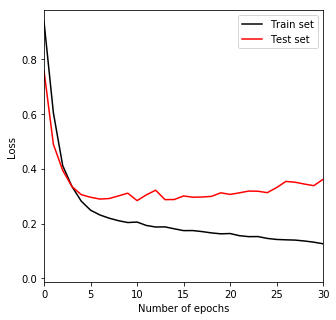

In [47]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(loss[0], color='k', label='Train set')
ax.plot(val_loss[0], color='r', label='Test set')
ax.set_xlabel('Number of epochs')
ax.set_ylabel('Loss')
ax.set_xlim(0,30)
ax.legend()


When the number of epochs increases from 1 to ~5, the loss function decreases on both the training and the test set. However, when the number of epochs is > 5, the loss function keeps decreasing on the training set but increases on the test set, which is a sign that the model is **overfitting**. We will keep the number of epochs equal to 4!

Let's see how our model performs:

In [74]:
model = compile_model()
our_model = model.fit(X_train, y_train, epochs=4, verbose=0)

In [75]:
y_pred0 = model.predict(X_test)

In [50]:
def print_f1score(model, X_train, y_train, y_test, y_pred):
    
    training_score = f1_score(np.argmax(y_train,axis=1), 
                              np.argmax(model.predict(X_train),axis=1), average='micro')

    test_score = f1_score(np.argmax(y_test,axis=1), 
                          np.argmax(y_pred,axis=1), average='micro')

    print('Training f1-score: %s'%training_score)
    print('Test f1-score: %s'%test_score)

print_f1score(model, X_train, y_train, y_test, y_pred0)

Training f1-score: 0.8823924731182796
Test f1-score: 0.8699059561128527


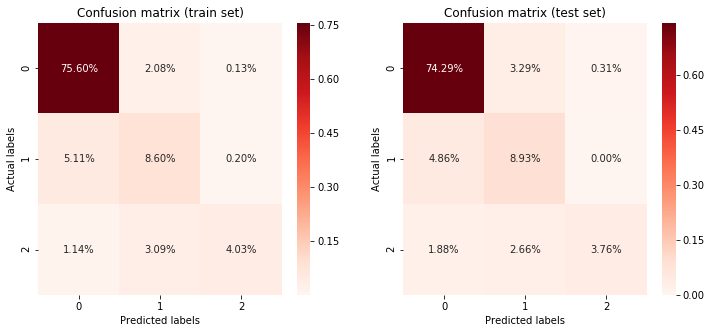

In [51]:
# Check out these nice tricks of Dennis T to plot confusion matrix
# [https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea]

def print_confusion_matrix(model, X_train, y_train, y_test, y_pred):
    train_confusion = confusion_matrix(np.argmax(y_train,axis=1), np.argmax(model.predict(X_train),axis=1))
    test_confusion = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))

    fig, ax = plt.subplots(1,2,figsize=(12,5))

    sns.heatmap(train_confusion/np.sum(train_confusion), ax=ax[0], annot=True, fmt='.2%', cmap='Reds')
    ax[0].set_xlabel('Predicted labels')
    ax[0].set_ylabel('Actual labels')
    ax[0].set_title('Confusion matrix (train set)')

    sns.heatmap(test_confusion/np.sum(test_confusion), ax=ax[1], annot=True, fmt='.2%', cmap='Reds')
    ax[1].set_title('Confusion matrix (test set)')
    ax[1].set_xlabel('Predicted labels')
    ax[1].set_ylabel('Actual labels')

print_confusion_matrix(model, X_train, y_train, y_test, y_pred0)

The confusion matrix show us that, on unseen data :
- 65.9% of the 'Suspect' foetus are correctly labeled
- 60.4% of the 'Pathological' foetus are correctly labeled

I am sure that we can do better ! One solution to reduce the proportion of false negatives and false positives is to perform a hyperparameter tuning. In a neural network model like that, the number of degrees of freedom is quite large. It is possible to modify the architecture of the network (number of layers, number of neurons per layer etc.), the activation functions, the optimizer etc. For the sake of simplicity, I will not tweak the architecture of the model. Let's find 'the best' activation functions and optimizer!

In [53]:
def my_new_model(act, opt):
    clear_session()
    model = Sequential()
    model.add(Dense(20, input_shape=(20,), activation=act))
    model.add(Dense(20, activation=act))
    model.add(Dense(20, activation=act))
    model.add(Dense(20, activation=act))
    model.add(Dense(20, activation=act))
    model.add(Dense(3, activation='sigmoid'))
    model.compile(optimizer=opt, loss='categorical_crossentropy')
    return model

new_model = KerasClassifier(build_fn=my_new_model, verbose=0)

parameters = dict(opt = ['adam', 'sgd', 'adamax'], act=['relu', 'softmax', 'tanh', 'selu'], 
                  epochs=np.arange(2, 15, 1), batch_size=[32, 64, 128, 256, 512])

random_search = RandomizedSearchCV(new_model, param_distributions=parameters, 
                                   n_iter=30, scoring='roc_auc', random_state=123)

res = random_search.fit(X_train, y_train)

print(res.best_params_)

{'opt': 'adam', 'epochs': 14, 'batch_size': 32, 'act': 'relu'}


In [54]:
#Let's see how we perform with the prescribed optimizer and activation function! 

optimized_model = my_new_model('relu', 'adam')

optimized_model.fit(X_train, y_train, epochs=14, batch_size=32, verbose=0)

y_pred = optimized_model.predict(X_test)

print_f1score(optimized_model, X_train, y_train, y_test, y_pred)

Training f1-score: 0.9240591397849462
Test f1-score: 0.9059561128526645


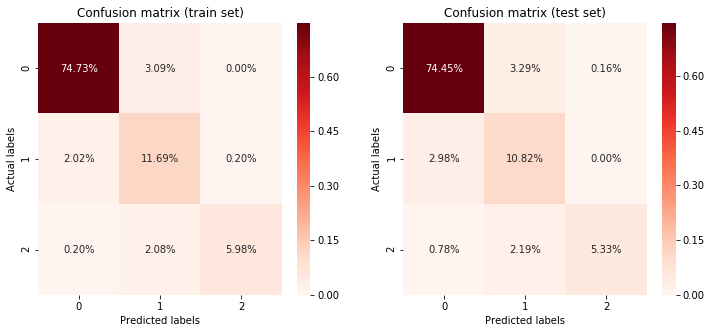

In [55]:
print_confusion_matrix(optimized_model, X_train, y_train, y_test, y_pred)

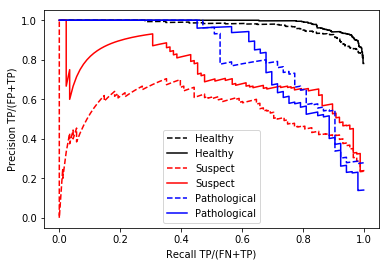

In [78]:
precision = dict()
recall = dict()
precision_opt = dict()
recall_opt = dict()

for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:,i],y_pred0[:,i])
    precision_opt[i], recall_opt[i], _ = precision_recall_curve(y_test[:,i],y_pred[:,i])

fig, ax = plt.subplots()

colors = ['k','r','b']
labels = ['Healthy','Suspect','Pathological']

for i in range(3):
    ax.plot(recall[i],precision[i],color=colors[i],label=labels[i],linestyle='--')
    ax.plot(recall_opt[i],precision_opt[i],color=colors[i],label=labels[i],linestyle='-')

ax.set_xlabel('Recall TP/(FN+TP)')
ax.set_ylabel('Precision TP/(FP+TP)')

plt.legend()
plt.show()

In [89]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1)))

             precision    recall  f1-score   support

          0       0.95      0.96      0.95       497
          1       0.66      0.78      0.72        88
          2       0.97      0.64      0.77        53

avg / total       0.91      0.91      0.91       638



**Results & Limits**:
The f1-score and the area under the precision-recall curve has improved with the hyperparameter tuning. The advantage of this method is its easiness, the approach is costless (in terms of human cost), and does not require an effort for feature engineering and/or selection. It can be approved by tuning other parameters (in particular the architecture of the model), by adding a batch normalization, a dropout layer etc. The strength of the model can be 

**COMING SOON** I'll publish soon the other approach with feature selection and different ensemble techniques, I have compared a voting classification technique, a random forest classifier and an extreme gradient boosting algorithm, the predictive  